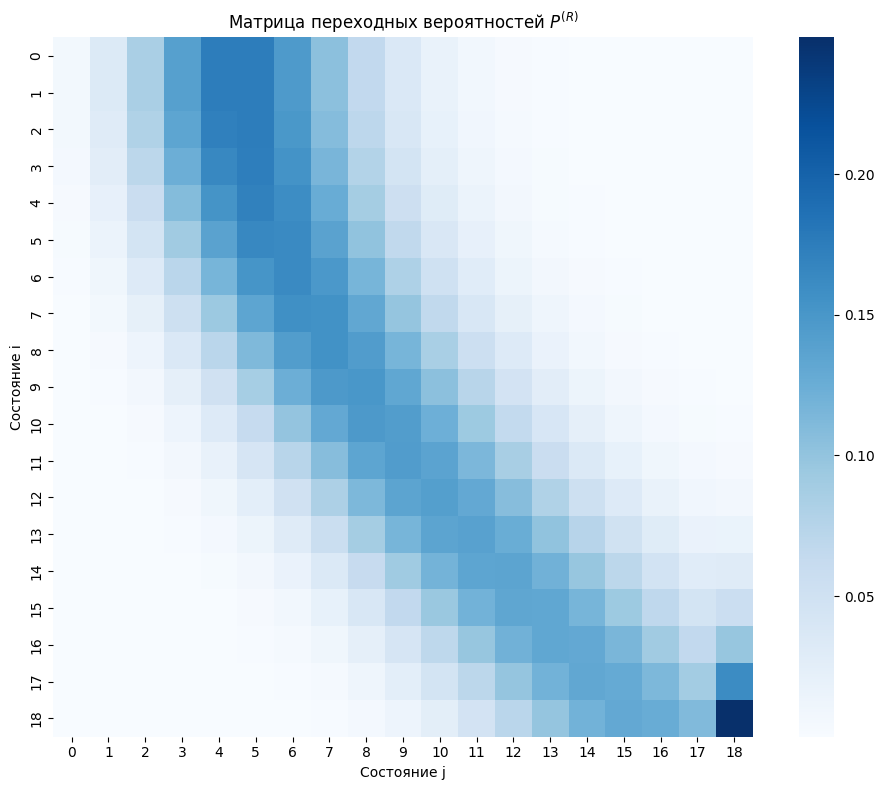

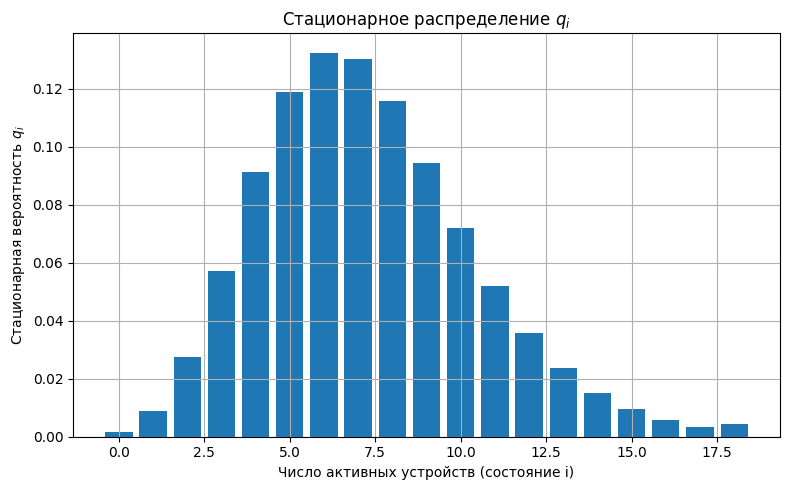

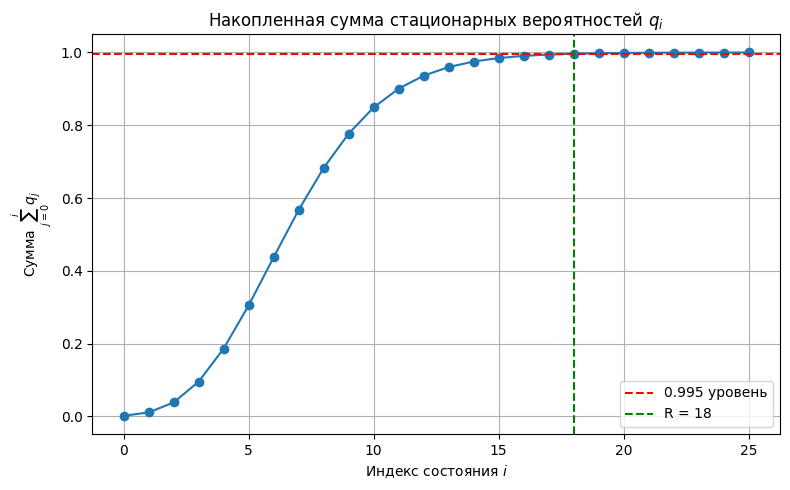

In [4]:
import math
from typing import List

def binomial_coeff(n: int, k: int) -> int:
    """Вычисляет биномиальный коэффициент C(n, k)."""
    return math.comb(n, k)

def beta_k_approx(k: int, r: int, L: int) -> float:
    """
    Аппроксимация β_k(r) по биномиальной формуле.
    """
    if r == 0:
        return 1.0 if k == 0 else 0.0
    m = min(L, r)
    if m == 0:  # добавим защиту от деления на 0
        return 0.0
    success_prob = (r * (1 - 1/L)**(r - 1)) / m
    if not (0 <= k <= m):
        return 0.0
    coeff = binomial_coeff(m, k)
    return coeff * (success_prob**k) * ((1 - success_prob)**(m - k))


def alpha_poisson(k: int, lam: float) -> float:
    return poisson.pmf(k, lam)
    

import numpy as np
from scipy.stats import poisson
from typing import Callable
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки
R = 18    # Максимальное число активных устройств
L = 20      # Число преамбул
λ = 5        # Среднее число новых устройств за кадр (параметр Пуассона)

# Построение матрицы переходных вероятностей P
P = np.zeros((R + 1, R + 1))

for i in range(R + 1):
    for j in range(R):  # Переходы в j < R
        for k in range(i + 1):
            delta = j - i + k
            if delta >= 0:
                P[i, j] += beta_k_approx(k, i, L) * alpha_poisson(delta, λ)

    # j = R: учитываем все оставшиеся вероятности (хвост)
    for k in range(i + 1):
        tail = 1 - sum(alpha_poisson(j - i + k, λ) for j in range(R) if j - i + k >= 0)
        P[i, R] += beta_k_approx(k, i, L) * tail

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(P, annot=False, cmap="Blues", cbar=True, square=True)
plt.title("Матрица переходных вероятностей $P^{(R)}$")
plt.xlabel("Состояние j")
plt.ylabel("Состояние i")
plt.tight_layout()
plt.show()

# Вычисление стационарного распределения q_i
# Найдём собственный вектор, соответствующий собственному значению 1

eigvals, eigvecs = np.linalg.eig(P.T)
stationary_index = np.argmin(np.abs(eigvals - 1))  # Ищем индекс λ ≈ 1
q = np.real(eigvecs[:, stationary_index])          # Берем соответствующий вектор
q /= np.sum(q)                                     # Нормируем

# Отображение
plt.figure(figsize=(8, 5))
plt.bar(range(R + 1), q)
plt.xlabel("Число активных устройств (состояние i)")
plt.ylabel("Стационарная вероятность $q_i$")
plt.title("Стационарное распределение $q_i$")
plt.grid(True)
plt.tight_layout()
plt.show()

# Вычисление среднего числа активных устройств (RA-фаза) — R̄
R_bar = sum(i * q[i] for i in range(1, R + 1))

# Вычисление среднего числа успешных устройств за кадр — θ̄
theta_bar = 0.0
for i in range(R + 1):
    for k in range(i + 1):
        theta_bar += q[i] * k * beta_k_approx(k, i, L)

# Средняя задержка в RA согласно формуле Литтла
# λ_r — интенсивность поступления заявок (по сути, λ)
w_r = R_bar / λ

R_bar, theta_bar, w_r

confidence = 0.995
R_max=λ*5


# Построение матрицы переходных вероятностей P
P_max = np.zeros((R_max + 1, R_max + 1))

for i in range(R_max + 1):
    for j in range(R_max):  # Переходы в j < R
        for k in range(i + 1):
            delta = j - i + k
            if delta >= 0:
                P_max[i, j] += beta_k_approx(k, i, L) * alpha_poisson(delta, λ)

    # j = R: учитываем все оставшиеся вероятности (хвост)
    for k in range(i + 1):
        tail = 1 - sum(alpha_poisson(j - i + k, λ) for j in range(R_max) if j - i + k >= 0)
        P_max[i, R_max] += beta_k_approx(k, i, L) * tail


# Вычисление стационарного распределения q_i
# Найдём собственный вектор, соответствующий собственному значению 1

eigvals, eigvecs = np.linalg.eig(P_max.T)
stationary_index = np.argmin(np.abs(eigvals - 1))  # Ищем индекс λ ≈ 1
q_max = np.real(eigvecs[:, stationary_index])          # Берем соответствующий вектор
q_max /= np.sum(q_max)                                     # Нормируем


cumulative_q_max = np.cumsum(q_max)
R_critical = np.argmax(cumulative_q_max >= confidence)
indices = np.arange(len(q_max))

# График накопленной суммы по q
plt.figure(figsize=(8, 5))
plt.plot(indices, cumulative_q_max, marker='o')
plt.axhline(confidence, color='red', linestyle='--', label=f"{confidence:.3f} уровень")
plt.axvline(R_critical, color='green', linestyle='--', label=f"R = {R_critical}")
plt.xlabel("Индекс состояния $i$")
plt.ylabel("Сумма $\\sum_{{j=0}}^{{i}} q_j$")
plt.title("Накопленная сумма стационарных вероятностей $q_i$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()